# Plotting the spectral function

In this tutorial we go through the steps to plot tight-binding bands from a Wannier90 Hamiltonian and spectralfunctions with analytically continued (real-frequency) self-energies obtained from DMFT.

In [1]:
%matplotlib inline
from IPython.display import display
from IPython.display import Image
import numpy as np
import importlib, sys
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

from ase.io.espresso import read_espresso_in

from h5 import HDFArchive
from solid_dmft.postprocessing import plot_correlated_bands as pcb

## Configuration

The script makes use of the `triqs.lattice.utils` class, which allows to set up a tight-binding model based on a Wannier90 Hamiltonian. Additionally, you may upload a self-energy in the usual `solid_dmft` format to compute correlated spectral properties.
Currently, the following options are implemented:
<ol>
<li>bandstructure</li>
<li>Fermi slice</li>
</ol>

### Basic options

We start with configuring these options. For this example we try a tight-binding bandstructure including the correlated bands (`kslice = False`, `'tb': True`, `'alatt': True`), but feel free to come back here to explore. Alternatively to an intensity plot of the correlated bands (`qp_bands`), you can compute the correlated quasiparticle bands assuming a Fermi liquid regime.\
The options for $\Sigma(\omega)$ are `calc` or `model`, which performs a Fermi liquid linearization in the low-frequency regime. The latter will be reworked, so better stick with `calc` for now.

In [2]:
kslice = False

bands_config = {'tb': True, 'alatt': True, 'qp_bands': False, 'sigma': 'calc'}
kslice_config = {'tb': True, 'alatt': True, 'qp_bands': False, 'sigma': 'calc'}
config = kslice_config if kslice else bands_config

### Wannier90

Next we will set up the Wannier90 Input. Provide the path, seedname, chemical potential and orbital order used in Wannier90. You may add a spin-component, and any other local Hamiltonian. For `t2g` models the orbital order can be changed (to `orbital_order_to`) and a local spin-orbit coupling term can be added (`add_lambda`). The spectral properties can be viewed projected on a specific orbital.

In [3]:
w90_path = './'
w90_dict = {'w90_seed': 'svo', 'w90_path': w90_path, 'mu': 12.3958, 'n_orb': 3,
            'orbital_order_w90': ['dxz', 'dyz', 'dxy'], 'add_spin': False, 'add_lambda': [0.1] * 3}

orbital_order_to = ['dxy', 'dxz', 'dyz']
proj_on_orb = None # or 'dxy' etc

### BZ configuration

#### Optional: ASE Brillouin Zone

It might be helpful to have a brief look at the Brillouin Zone by loading an input file of your favorite DFT code (Quantum Espresso in this case). ASE will write out the special $k$-points, which we can use to configure the BZ path. Alternatively, you can of course define the dictionary `kpts_dict` yourself. Careful, it might not define $Z$, which is needed and added below.

G [0. 0. 0.]
M [0.5 0.5 0. ]
R [0.5 0.5 0.5]
X [0.  0.5 0. ]


<Axes3DSubplot:>

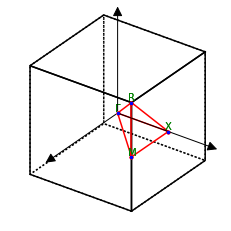

In [4]:
scf_in = './svo.scf.in'

# read scf file
atoms = read_espresso_in(scf_in)
# set up cell and path
lat = atoms.cell.get_bravais_lattice()
path = atoms.cell.bandpath('', npoints=100)
kpts_dict = path.todict()['special_points']

for key, value in kpts_dict.items():
    print(key, value)
lat.plot_bz()

---

Depending on whether you select `kslice=True` or `False`, a corresponding `tb_config` needs to be provided containing information about the $k$-points, resolution (`n_k`) or `kz`-plane in the case of the Fermi slice. Here we just import the $k$-point dictionary provided by ASE above and add the $Z$-point. If you are unhappy with the resolution of the final plot, come back here and crank up `n_k`. For the kslice, the first letter corresponds to the upper left corner of the plotted Brillouin zone, followed by the lower left corner and the lower right one ($Y$, $\Gamma$, and $X$ in this case).

In [5]:
# band specs
tb_bands = {'bands_path': [('R', 'G'), ('G', 'X'), ('X', 'M'), ('M', 'G')], 'Z': np.array([0,0,0.5]), 'n_k': 50}
tb_bands.update(kpts_dict)

# kslice specs
tb_kslice = {key: tb_bands[key] for key in list(tb_bands.keys()) if key.isupper()}
kslice_update = {'bands_path': [('Y', 'G'),('G', 'X')], 'Y': np.array([0.5,0.0,0]), 'n_k': 50, 'kz': 0.0}
tb_kslice.update(kslice_update)

tb_config = tb_kslice if kslice else tb_bands

### Self-energy

Here we provide the info needed from the h5Archive, like the self-energy, iteration count, spin and block component and the frequency mesh used for the interpolation. The values for the mesh of course depend on the quantity of interest. For a kslice the resolution around $\omega=0$ is crucial and we need only a small energy window, while for a bandstructure we are also interested in high energy features.

In [6]:
freq_mesh_kslice = {'window': [-0.5, 0.5], 'n_w': int(1e6)}
freq_mesh_bands = {'window': [-5, 5], 'n_w': int(1e3)}
freq_mesh = freq_mesh_kslice if kslice else freq_mesh_bands

dmft_path = './svo_example.h5'

sigma_dict = {'dmft_path': dmft_path, 'it': 'last_iter', 'orbital_order_dmft': orbital_order_to, 'spin': 'up',
              'block': 0, 'eta': 0.0, 'w_mesh': freq_mesh, 'linearize': False}

__Optional__: for completeness and as a sanity check we quickly take a look at the self-energy. Make sure you provide a physical one!

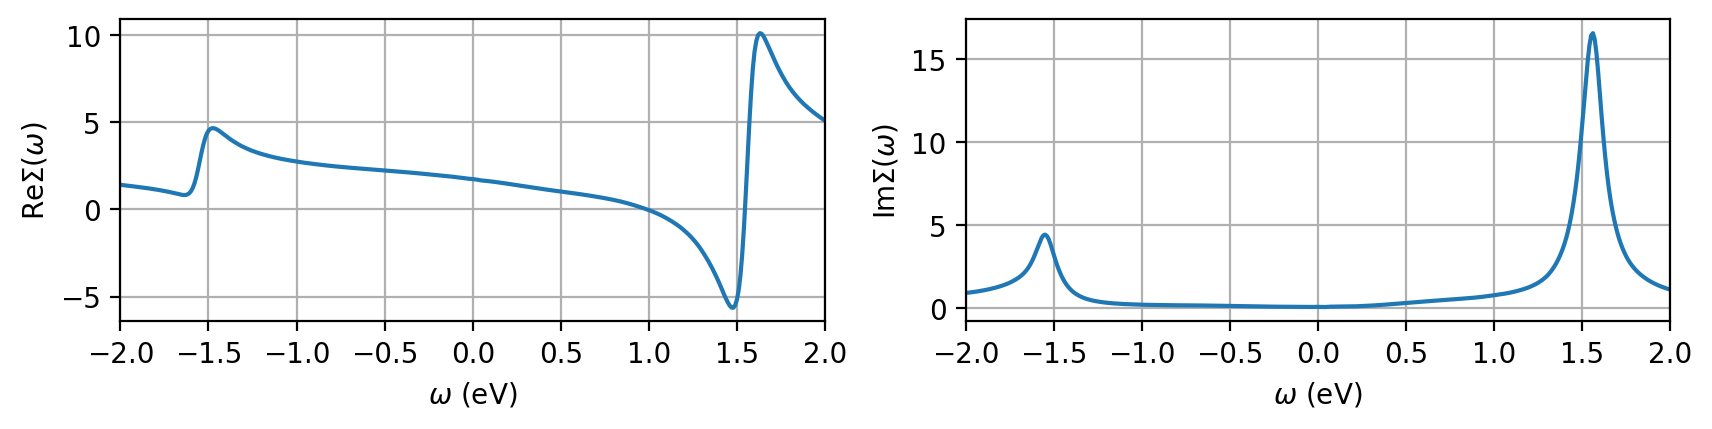

In [7]:
with HDFArchive(dmft_path, 'r') as h5:
    sigma_freq = h5['DMFT_results']['last_iter']['Sigma_freq_0']

fig, ax = plt.subplots(1, 2, figsize=(10,2), squeeze=False, dpi=200)

orb = 0
sp = 'up_0'
freq_mesh = np.array([w.value for w in sigma_freq[sp][orb,orb].mesh])

ax[0,0].plot(freq_mesh, sigma_freq[sp][orb,orb].data.real)
ax[0,1].plot(freq_mesh, -sigma_freq[sp][orb,orb].data.imag)

ax[0,0].set_ylabel(r'Re$\Sigma(\omega)$')
ax[0,1].set_ylabel(r'Im$\Sigma(\omega)$')
for ct in range(2):
    ax[0,ct].grid()
    ax[0,ct].set_xlim(-2, 2)
    ax[0,ct].set_xlabel(r'$\omega$ (eV)')

### Plotting options

Finally, you can choose colormaps for each of the functionalities from any of the available on <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">matplotlib colormaps</a>. `vmin` determines the scaling of the logarithmically scaled colorplots. The corresponding tight-binding bands will have the maximum value of the colormap. By the way, colormaps can be reversed by appending `_r` to the identifier.

In [8]:
proj_on_orb = orbital_order_to.index(proj_on_orb) if proj_on_orb else None
plot_config = {'colorscheme_bands': 'coolwarm', 'colorscheme_kslice': 'PuBuGn',
               'colorscheme_qpbands': 'Greens', 'vmin': 0.1, 'proj_on_orb': proj_on_orb}

## Run and Plotting

Now that everything is set up we may hit run. Caution, if you use a lot of $k$-points, this may take a while! In the current example, it should be done within a second.

In [9]:
start_time = timer()

tb_data, alatt_k_w, freq_dict, dft_mu = pcb.get_dmft_bands(fermi_slice=kslice, with_sigma=bands_config['sigma'],
                                                           orbital_order_to=orbital_order_to, qp_bands=config['qp_bands'],
                                                           **w90_dict, **tb_config, **sigma_dict)

print('Run took {0:.3f} s'.format(timer() - start_time))

Starting serial run at: 2022-02-07 14:25:44.772668


H(R=0):
      0.5811+0.0000j  0.0000+0.0000j  0.0000+0.0000j
      0.0000+0.0000j  0.5811+0.0000j  0.0000+0.0000j
      0.0000+0.0000j  0.0000+0.0000j  0.5811+0.0000j
Setting Sigma from ./svo_example.h5
Run took 1.140 s


That's it. Now you can look at the output:

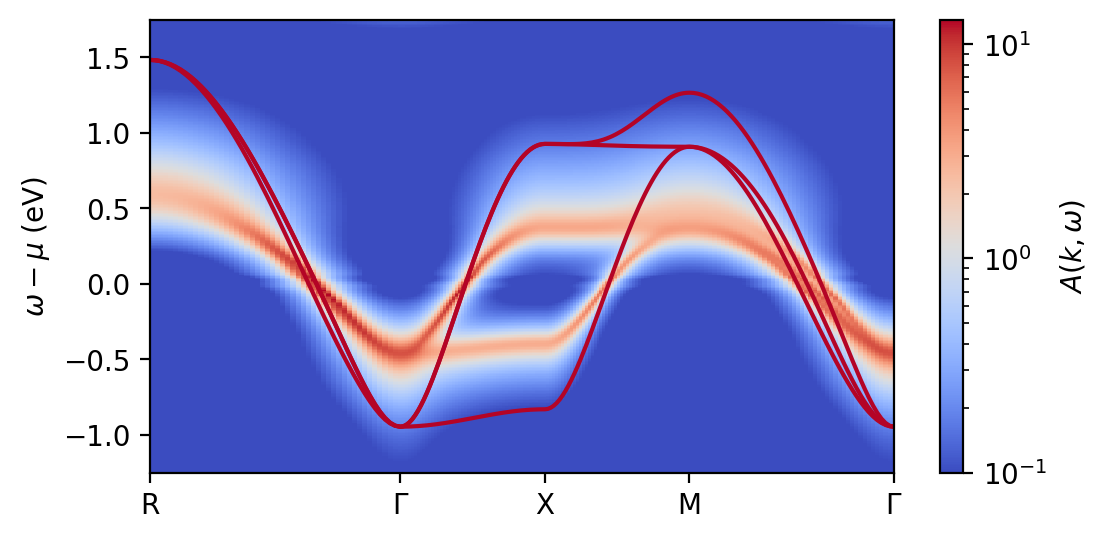

In [10]:
if kslice:
    fig, ax = plt.subplots(1, figsize=(3,3), dpi=200)

    pcb.plot_kslice(fig, ax, alatt_k_w, tb_data, freq_dict, w90_dict['n_orb'], tb_config,
                    tb=config['tb'], alatt=config['alatt'], quarter=0, **plot_config)

else:
    fig, ax = plt.subplots(1, figsize=(6,3), dpi=200)

    pcb.plot_bands(fig, ax, alatt_k_w, tb_data, freq_dict, w90_dict['n_orb'], dft_mu=0.,
                   tb=config['tb'], alatt=config['alatt'], qp_bands=config['qp_bands'], **plot_config)

    ax.set_ylim(-1.25,1.75)

---